## 0. Dependencies

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tag import pos_tag
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

import re
import json

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC


# import gensim 
# from gensim.models import Word2Vec

import multiprocessing as mp


## 1. Load in the data
This code loads in my bank transactions which consists of a date, amount, description and account balance. Then, if the transaction appears in my labelled dataset, it adds its labelled class with a join. 

A transaction is considered the same if it has the same description and amount to account for the fact that some purchases with the same description are in different classes (e.g. fuel vs. food is differentiated by the amount spent at the petrol station)

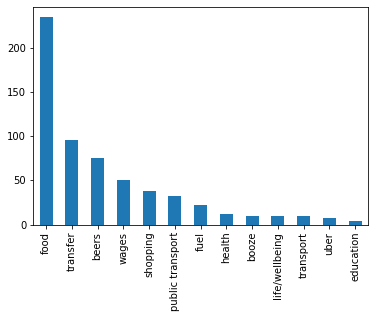

In [10]:
# Load in data

data = pd.read_csv("../components/files/CSVData.csv", header=None)
data.columns = ["date", "amount", "description", "balance"]
data['date']  = pd.to_datetime(data['date'], format='%d/%m/%Y')
data = data.drop("balance", axis=1)
data = data.astype({'amount':'float'})

# Load in labels and join to data

labels = pd.read_csv("../components/files/transactions_labelled.csv")
labels = labels.drop("date", axis=1)
labels = labels.drop_duplicates()


labels.description = labels.description.str.strip()
labels.description = labels.description.str.lower()
data.description = data.description.str.strip()
data.description = data.description.str.lower()


data_labs = data.merge(labels, on=["description", "amount"], how="left", validate="many_to_one")

data_labs.category.value_counts().plot(kind='bar')


This narrows down the categories to 7:
1. food
2. transfers
3. beers
4. transport
5. wages
6. shopping
7. life/wellbeing

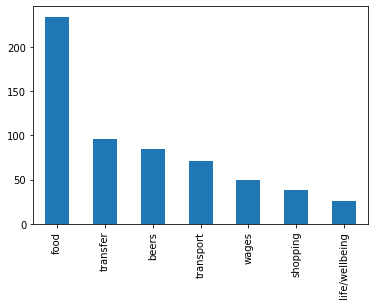

In [11]:
# Merge some of the underrepresented labels

data_labs.category = ["beers" if cat == "entertainment" else cat for cat in data_labs.category]
data_labs.category = ["beers" if cat == "booze" else cat for cat in data_labs.category]
data_labs.category = ["wages" if cat == "tutoring" else cat for cat in data_labs.category]
data_labs.category = ["health" if cat == "education" else cat for cat in data_labs.category]
data_labs.category = ["life/wellbeing" if cat == "health" else cat for cat in data_labs.category]
data_labs.category = ["transfer" if cat == "donation" else cat for cat in data_labs.category]
data_labs.category = ["transport" if cat in ["uber", "public transport", "fuel"] else cat for cat in data_labs.category]

data_labs.reset_index()
data_labs.category.value_counts().plot(kind='bar')


Some transactions are not processed immediately at the point of sale. When the bank transaction is finally approved, my bank records this as the date and appends the actual date of the transaction (which may have been up to 5 days in the past, the average I found was a 3 day delay) to the end of the description as "Value Date: dd/mm/YYYY". If the transaction goes through immediately, it just records the current date and leaves the description as is. (At least, this is the process that I inferred. I was unable to find any documentation to confirm this.)

Hence, I had to do a little scraping to collect these value dates when they appeared so that I had the date of the actual transaction.

In [12]:
# Scrape descriptions for "value date" (actual date of transaction)

value_dates = []
for desc in data_labs.description:
    if "value date: " in desc:
        val_date = desc.split("value date: ")[1]
        val_date = val_date.strip()
        value_dates.append(val_date)
    else:
        value_dates.append(None)
value_dates = np.array(value_dates)
data_labs["value_date"] = value_dates
data_labs.value_date = pd.to_datetime(data_labs.value_date, format='%d/%m/%Y')

# If there is no value date in the description, 
# it is assumed that the date of the record is the date of the transaction.

transaction_date = []
for index, row in data_labs.iterrows():
    if pd.isnull(row.value_date):
        transaction_date.append(row.date)
    else:
        transaction_date.append(row.value_date)
        
data_labs["trans_date"] = transaction_date
data_labs


,date,amount,description,category,value_date,trans_date
0,2020-07-27,50.0,direct credit 002962 citigroup ptyltd paddy walsh,wages,NaT,2020-07-27
1,2020-07-27,-4.8,mcdonalds gladesville gladesville nswau,food,NaT,2020-07-27
2,2020-07-27,-4.0,mcdonalds gladesville gladesville nswau,food,NaT,2020-07-27
3,2020-07-26,50.0,transfer from margaret a jorgensen izzy tutoring,wages,NaT,2020-07-26
4,2020-07-25,-14.5,chargrill mosman mosman au,food,NaT,2020-07-25
...,...,...,...,...,...,...
595,2019-09-13,-36.0,liquorland 3638 glebe au aus card xx6725 value...,beers,2019-09-11,2019-09-11
596,2019-09-12,-42.2,uberuae_eats sydney au aus card xx6725 value d...,food,2019-09-09,2019-09-09
597,2019-09-12,-13.0,eastern suburbs dist bellevue hill ns aus card...,beers,2019-09-06,2019-09-06
598,2019-09-12,19.0,return uberuae_eats sydney au aus card xx6725 ...,food,2019-09-09,2019-09-09


## 2. Feature Extraction

### 2.1 Weekend
Next, I wanted to pull out some interesting features. I figured whether the transaction occurred on a weekend would be telling. Initially I was going to just use a boolean isWeekend column marking when the weekday was 4, 5 or 6 (friday, saturday or sunday), but then I thought to let the models determine a cut off naturally, leaving the weekday as an integer.

In [13]:

tr_data = data_labs.drop(["date", "value_date"], axis=1)
tr_data.columns = ["amount", "description", "category", "date"]
tr_data["weekday"] = tr_data.date.dt.weekday
# tr_data["weekend"] = [True if day >= 4 else False for day in tr_data.weekday]
# tr_data = tr_data.drop("weekday", axis=1)
tr_data

# print(float(False))

,amount,description,category,date,weekday
0,50.0,direct credit 002962 citigroup ptyltd paddy walsh,wages,2020-07-27,0
1,-4.8,mcdonalds gladesville gladesville nswau,food,2020-07-27,0
2,-4.0,mcdonalds gladesville gladesville nswau,food,2020-07-27,0
3,50.0,transfer from margaret a jorgensen izzy tutoring,wages,2020-07-26,6
4,-14.5,chargrill mosman mosman au,food,2020-07-25,5
...,...,...,...,...,...
595,-36.0,liquorland 3638 glebe au aus card xx6725 value...,beers,2019-09-11,2
596,-42.2,uberuae_eats sydney au aus card xx6725 value d...,food,2019-09-09,0
597,-13.0,eastern suburbs dist bellevue hill ns aus card...,beers,2019-09-06,4
598,19.0,return uberuae_eats sydney au aus card xx6725 ...,food,2019-09-09,0


### 2.2 Natural Language Processing
Bank descriptions are limited to only a few characters. Hence, the text differs to most NLP texts in a few areas:
1. Most of the words are meaningful
2. Shortened words are common

Due to point 1, stopwords are not that common. But in the rare case they appear, it wouldn't hurt to filter them out so that's what we do. I also add a few terms to the blacklist that appear commonly at the end of most descriptions and are hence meaningless in terms of class differentiation, e.g. "card", "aus", "ns", etc.

To address point 2, I proposed a very naive approach were I essentially "chop up" larger words down to a length of three in the following manner:
If given the word "McDonalds", we would add to our corpus the words "McDonalds", "McDonald", "McDonal", "McDona", "McDon", "McDo", "McD". 

The thinking is if some McDonald's restaurant has a different transaction description convention (stupid example, but bear with) and they shorten the word McDonalds to McDon, then our machine learning algorithm will see that "McDonalds" and "McDon" should pretty much be seen as the same thing. 

Again, this is the naive, first attempt at accounting for point 2. 



In [14]:

stopword_list = stopwords.words('english')
blacklist = stopword_list + ['card', 'aus', 'au', 'ns', 'nsw', 'xx']

def clean_chop(string):
    corpus = ""
    out = string
    if "value date: " in out:
        out = out.split("value date: ")[0]
    out = re.sub(r'([^a-z ]+)', " ", out) # remove non-alphabetic characters
    out = out.strip().split(" ")
    for word in out:
        if word not in blacklist and len(word) > 1 and " " + word + " " not in corpus: # ensuring no duplicates
            wrd = word
            while len(wrd) >= 3:
                corpus += wrd + " "
                wrd = wrd[0:-1]
    return corpus.strip()


def clean(string):
    features = ""
    out = string
    if "value date: " in out:
        out = out.split("value date: ")[0]
    out = re.sub(r'([^a-z ]+)', " ", out) # remove non-alphabetic characters
    for word in out.strip().split(" "):
        if word not in blacklist and len(word) > 1 and " " + word + " " not in features: # ensuring no duplicates
            features += word + " "
    return features.strip()

def clean_chop_devowel(string):
    corpus = ""
    out = string
    if "value date: " in out:
        out = out.split("value date: ")[0]
    out = re.sub(r'([^a-z ]+)', " ", out) # remove non-alphabetic characters
    out = out.strip().split(" ")
    for word in out:
        if word not in blacklist and len(word) > 1 and " " + word + " " not in corpus: # ensuring no duplicates
            corpus += re.sub(r'([aeiou])+', "", word) + " " # Add devowelled word
            wrd = word
            while len(wrd) >= 3:
                corpus += wrd + " "
                wrd = wrd[0:-1]
    return corpus.strip()

def clean_devowel(string):
    features = ""
    out = string
    if "value date: " in out:
        out = out.split("value date: ")[0]
    out = re.sub(r'([^a-z ]+)', " ", out) # remove non-alphabetic characters
    for word in out.strip().split(" "):
        if word not in blacklist and len(word) > 1 and " " + word + " " not in features: # ensuring no duplicates
            features += re.sub(r'([aeiou])+', "", word) + " "
            features += word + " "
    return features.strip()


tr_data["desc_corpus"] = [clean_chop(desc) for desc in tr_data.description]
tr_data["desc_features"] = [clean(desc) for desc in tr_data.description]
tr_data

,amount,description,category,date,weekday,desc_corpus,desc_features
0,50.0,direct credit 002962 citigroup ptyltd paddy walsh,wages,2020-07-27,0,direct direc dire dir credit credi cred cre ci...,direct credit citigroup ptyltd paddy walsh
1,-4.8,mcdonalds gladesville gladesville nswau,food,2020-07-27,0,mcdonalds mcdonald mcdonal mcdona mcdon mcdo m...,mcdonalds gladesville nswau
2,-4.0,mcdonalds gladesville gladesville nswau,food,2020-07-27,0,mcdonalds mcdonald mcdonal mcdona mcdon mcdo m...,mcdonalds gladesville nswau
3,50.0,transfer from margaret a jorgensen izzy tutoring,wages,2020-07-26,6,transfer transfe transf trans tran tra margare...,transfer margaret jorgensen izzy tutoring
4,-14.5,chargrill mosman mosman au,food,2020-07-25,5,chargrill chargril chargri chargr charg char c...,chargrill mosman
...,...,...,...,...,...,...,...
595,-36.0,liquorland 3638 glebe au aus card xx6725 value...,beers,2019-09-11,2,liquorland liquorlan liquorla liquorl liquor l...,liquorland glebe
596,-42.2,uberuae_eats sydney au aus card xx6725 value d...,food,2019-09-09,0,uberuae uberua uberu uber ube eats eat sydney ...,uberuae eats sydney
597,-13.0,eastern suburbs dist bellevue hill ns aus card...,beers,2019-09-06,4,eastern easter easte east eas suburbs suburb s...,eastern suburbs dist bellevue hill
598,19.0,return uberuae_eats sydney au aus card xx6725 ...,food,2019-09-09,0,return retur retu ret uberuae uberua uberu ube...,return uberuae eats sydney


Here, I define a get_corpus function that will collect the corpus of each class. The idea is to collect a list of words for each class. The list of words will in some way characterise the class. I added a threshold parameter which I can adjust to only count words that appear a certain number of times in a particular class. If the word "panther" appears in only one "food" entry, then its unlikely that a description containing "panther" would generalise to every food item.

In [15]:
def get_corpus(training):
    global_corpus = {}
    for cat in training.category.unique():
        corp = {}
        for index, row in training[training.category == cat].iterrows():    # Counting appearances of each corpus candidate within the class
            words = row.desc_corpus.split(" ")
            for word in words:
                if word not in corp.keys():
                    corp[word] = 1
                else:
                    corp[word] += 1
        
        # Order the words in descending frequency
        words = {k: v for k, v in sorted(corp.items(), key=lambda item: (item[1], 1/len(item[0])), reverse=True)}
        freq = np.array(list(words.values()))
        perc = freq/tr_data[tr_data.category == cat].shape[0]
        thresh = 0                             # number of entries a candidate must occur within the class for it to be added to the corpus
        features = []
        for word, count in zip(words.keys(), freq):
            if count > thresh:
                features.append(word)
        global_corpus[cat] = features
    # file = open("administration/corpus.json", "w")
    # json.dump(global_corpus, file)
    # file.close()
    return global_corpus


Then, for each entry, we compare its description features (the description stripped of all numbers and punctuation) to the corpus of each class (found with the function above). The way I initially chose to do this is rather naive. Firstly I take each word in the entry's description features and compare its similarity to each word in the corpus of a given class (using the jaccard distance because its computationally efficient). It then tries all words in the class corpus and returns the minimum (this will be 0 if it finds an exact match). It does this for all the words in the description features, then takes an average of the minimum distances. This is how I estimate the "closeness" of each description to the class corpus of each class.

In [16]:
# distance = nltk.edit_distance
def distance(string1, string2):
    return nltk.jaccard_distance(set(string1), set(string2))

def desc_dist(corpus, desc):
    if len(corpus) == 0:
        return 100
    min_distances = []
    min_dist = np.inf
    for feature in desc.split(" "):
        for corp in corpus:                 # Find the minimum distance that each feature has to any corpus item (best possible match)
            dist = distance(feature, corp)
            if dist < min_dist:
                min_dist = dist
        if not np.isfinite(min_dist): 
            min_dist = 100
        min_distances.append(min_dist)
    return np.mean(min_distances)  


def NLP_distances(data, corpus):
    for cat, corp in corpus.items():
        data[cat + "_desc_dist"] = [desc_dist(corp, desc) for desc in data.desc_features]
    data = data.drop(["description", "date", "desc_features", "desc_corpus"], axis=1)
    data = data[list(set(list(data.columns)) - set(['category']))+ ['category']]
    return data


In [17]:
labelled_data = tr_data[~pd.isnull(tr_data.category)]

labelled_data = NLP_distances(labelled_data, get_corpus(labelled_data))

labelled_data


,life/wellbeing_desc_dist,transfer_desc_dist,wages_desc_dist,beers_desc_dist,shopping_desc_dist,food_desc_dist,weekday,transport_desc_dist,amount,category
0,0.000000,0.000000,0.000000,0.166667,0.364286,0.337302,0,0.476190,50.0,wages
1,0.125000,0.400000,0.407407,0.125000,0.125000,0.000000,0,0.125000,-4.8,food
2,0.125000,0.400000,0.407407,0.125000,0.125000,0.000000,0,0.125000,-4.0,food
3,0.443636,0.000000,0.000000,0.142857,0.346667,0.250000,6,0.285714,50.0,wages
4,0.142857,0.285714,0.285714,0.222222,0.250000,0.000000,5,0.272727,-14.5,food
...,...,...,...,...,...,...,...,...,...,...
595,0.400000,0.500000,0.352273,0.000000,0.222222,0.166667,2,0.500000,-36.0,beers
596,0.133333,0.266667,0.300000,0.111111,0.266667,0.000000,0,0.133333,-42.2,food
597,0.405714,0.142857,0.142857,0.000000,0.428571,0.114286,4,0.133333,-13.0,beers
598,0.000000,0.000000,0.332143,0.166667,0.000000,0.000000,0,0.125000,19.0,food


Some of the models I want to use (e.g. nearest neighbour) will require the data be scaled. So the following section is where I explored how to do that.

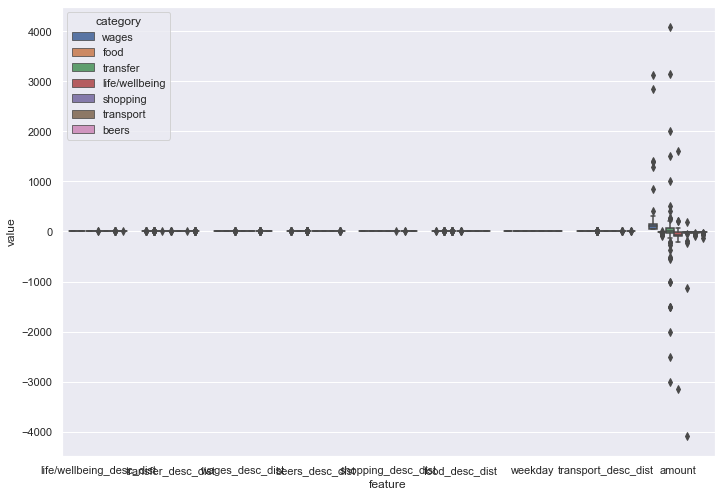

In [18]:


sns.set(rc={'figure.figsize':(11.7,8.27)})

(labelled_data.set_index('category', append=True)  # set "category" as part of the index
    .stack()                      # pull A - D into rows 
    .to_frame()                   # convert to a dataframe
    .reset_index()
    .rename(columns={'level_2': 'feature', 0: 'value'})
    .drop('level_0', axis='columns')
    .pipe((sns.boxplot, 'data'), x='feature', y='value', hue='category')
)
# sns.despine(trim=True)




In [21]:

def scale(data):
    scaler = StandardScaler()

    norm_data = data.drop("category", axis=1)

    norm_data = scaler.fit_transform(norm_data)

    norm_data = pd.DataFrame(norm_data, columns = list(set(data.columns) - set(['category'])), index = data.index)
    norm_data['category'] = data.category
    return norm_data

norm_data = scale(labelled_data)

Finally, I plan to use cross validation to evaluate my models. The following code is how I implement cross validation with multiprocessing so it doesnt take decades each time.

In [22]:
def run_fold(X, y, split, ml_model):
    model = ml_model
    train_index, test_index = split
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = X_train.category, X_test.category
    
    corpus = get_corpus(X_train)
    X_train = NLP_distances(X_train, corpus).drop('category', axis=1)
    X_train = scale(X_train)
    X_test = NLP_distances(X_test, corpus).drop('category', axis=1)
    X_test = scale(X_test)
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    acc = sum(predictions == y_test)/len(predictions)
    return acc

accuracies = []
def record(acc):
    accuracies.append(acc)
    
n_folds = 10
    
ml_model = LinearSVC(max_iter=50000)
        

# Remove unknown transactions
eval_data = norm_data

X = eval_data
y = eval_data.category

splitter = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=123)
folds = list(splitter.split(X, y))

print("Performing " + str(n_folds) + "-fold cross validation")

pool = mp.Pool(10)
for fold in folds:
    pool.apply_async(run_fold, args=(X, y, fold, ml_model), callback = record)
pool.close()
pool.join()

print("Average over "+ str(n_folds) + " folds: "  + str(round(np.mean(accuracies), 3)))



tr(folds) + " folds: " + str(round(np.mean(accuracies), 4))


Performing 10-fold cross validation


KeyboardInterrupt: 